ADAPTIVE PERSUASION SYSTEM - PRODUCTION VERSION

In [3]:
!pip install -q transformers>=4.40.0 huggingface_hub>=0.23.0 torch
!pip install -q textblob nltk pandas numpy matplotlib

import torch, transformers, textblob, nltk, pandas, numpy, matplotlib
print("All required libraries are installed and imported successfully.")


c:\Users\Affan\Desktop\Futwork\Persuation_System\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All required libraries are installed and imported successfully.


In [4]:
# Imports

import os
import json
import re
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import random

from huggingface_hub import InferenceClient, login
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from textblob import TextBlob
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML


# NLTK Downloads
nltk.download('punkt', quiet=True)
nltk.download('vader_lexicon', quiet=True)


True

In [5]:
# Authentication

HF_TOKEN = os.getenv("HF_TOKEN")
os.environ['HF_TOKEN'] = HF_TOKEN

try:
    login(token=HF_TOKEN, add_to_git_credential=False)
    print("Authenticated\n")
except Exception as e:
    print(f"Failed: {e}")
    raise

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Authenticated



In [6]:
# Loading the llama 3.1 model

MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        token=HF_TOKEN,
        torch_dtype=torch.float16,
        device_map="auto",
        low_cpu_mem_usage=True
    )
    print("Model loaded successfully!\n")
    USE_LOCAL_MODEL = True
except Exception as e:
    print(f"Could not load model locally: {e}")
    print("Falling back to Inference API until access is approved\n")
    USE_LOCAL_MODEL = False
    client = InferenceClient(api_key=HF_TOKEN)


c:\Users\Affan\Desktop\Futwork\Persuation_System\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Affan\.cache\huggingface\hub\models--meta-llama--Llama-3.1-8B-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
`torch_dtype` is deprecated! Use `dtype` instead!


Could not load model locally: Using a `device_map`, `tp_plan`, `torch.device` context manager or setting `torch.set_default_device(device)` requires `accelerate`. You can install it with `pip install accelerate`
Falling back to Inference API until access is approved



In [7]:
# CAMPAIGN SETUP

org_name = input("Organization [Children's Education Fund]: ").strip() or "Children's Education Fund"
cause = input("Cause [education for children]: ").strip() or "providing education to underprivileged children"
amounts = input("Amounts [200,500,1000]: ").strip() or "200, 500, 1000"
impact = input("Impact [₹200 = 5 kids supplies]: ").strip() or "₹200 provides school supplies for 5 children for a month"

DONATION_CONTEXT = {
    'organization': org_name,
    'cause': cause,
    'amounts': amounts,
    'impact': impact
}

print("\nCampaign ready\n")


Campaign ready



In [8]:
# CONFIGURATION

class Config:
    MODEL_NAME = MODEL_NAME
    TEMPERATURE = 0.8
    MAX_NEW_TOKENS = 64

    INITIAL_BELIEF = 0.05
    INITIAL_TRUST = 1.0
    TRUST_THRESHOLD = 0.5

    ALPHA = 0.1
    BETA = 0.15
    GAMMA = 0.08

    HARD_REJECTION_PENALTY = 0.4
    SOFT_REJECTION_PENALTY = 0.2
    MIN_STRATEGY_WEIGHT = 0.05

    MAX_TURNS = 15
    MAX_CONSECUTIVE_REJECTIONS = 3

    LOG_FILE = "dialogue_log.jsonl"
    STRATEGIES = ["Empathy", "Impact", "SocialProof", "Transparency", "EthicalUrgency"]

In [9]:
# REJECTION DETECTOR

class RejectionDetector:

    # EXPLICIT NO - very clear rejection
    EXPLICIT_PATTERNS = [
        r'\b(no thanks|no thank you|not interested|don\'t want|won\'t donate)\b',
        r'\b(nope|nah|never|absolutely not|definitely not)\b',
        r'\b(leave me alone|stop asking|not doing|refuse)\b'
    ]

    # SOFT NO - hesitation, delay
    SOFT_PATTERNS = [
        r'\b(maybe later|not now|not right now|some other time|another time)\b',
        r'\b(not today|can\'t right now|busy right now)\b',
        r'\b(not sure|unsure|uncertain|hesitant|doubtful)\b',
        r'\b(can\'t afford|no money|tight budget|broke|expensive)\b',
        r'\b(i\'ll think|let me think|need time|consider)\b'
    ]

    # TRUST ISSUES
    TRUST_PATTERNS = [
        r'\b(pushy|aggressive|pressure|uncomfortable|sketchy|scam|fraud)\b',
        r'\b(suspicious|don\'t trust|seems fake|sounds fake)\b',
        r'\b(why are you|what\'s your motive|prove it)\b'
    ]

    # CURIOSITY - asking questions, wanting info
    CURIOSITY_PATTERNS = [
        r'\b(tell me more|tell me about|what about|explain|how does|how do)\b',
        r'\b(more info|more details|details|information)\b',
        r'\b(curious|interested in learning|want to know|want to hear)\b',
        r'\b(what is|who are|where does|when|why)\b',
        r'\b(can you|could you|would you.*explain|show me)\b'
    ]

    # ACTUAL COMMITMENT - very explicit intent to donate
    ACCEPTANCE_PATTERNS = [
        r'\b(yes.*i.*donate|i will donate|i\'ll donate|i want to donate)\b',
        r'\b(sign me up|count me in|i\'m in)\b',
        r'\b(where do i donate|how do i donate|how can i donate)\b',
        r'\b(i\'ll give|i will give|i want to give ₹|i can give ₹)\b',
        r'\b(okay.*donate|ok.*donate|sure.*donate|let\'s do it)\b',
        r'\b(take my donation|here\'s my donation|ready to donate)\b'
    ]


    def __init__(self):
        self.sentiment = None

    def detect(self, user_message: str) -> Dict:
        msg = user_message.lower().strip()

        # First check: ACTUAL donation commitment
        if self._match(msg, self.ACCEPTANCE_PATTERNS):
            return {
                'rejection_type': 'none',
                'rejection_confidence': 0.0,
                'trust_concern': False,
                'sentiment_score': 0.9,
                'sentiment_label': 'positive',
                'is_acceptance': True,
                'is_curiosity': False
            }

        # Check curiosity
        is_curiosity = self._match(msg, self.CURIOSITY_PATTERNS)

        # Check rejection
        rejection_type = 'none'
        confidence = 0.0

        if self._match(msg, self.EXPLICIT_PATTERNS):
            rejection_type = 'explicit'
            confidence = 0.9
        elif self._match(msg, self.SOFT_PATTERNS):
            rejection_type = 'soft'
            confidence = 0.7

        # Trust concerns
        trust_concern = self._match(msg, self.TRUST_PATTERNS)

        # Sentiment
        sent_score, sent_label = self._get_sentiment(user_message)

        # Special handling
        if is_curiosity and rejection_type == 'none':
            rejection_type = 'curiosity'
            sent_score = max(0.2, sent_score)

        if sent_score < -0.4 and rejection_type == 'none':
            rejection_type = 'ambiguous'
            confidence = 0.5

        if sent_score < -0.6 and rejection_type == 'soft':
            rejection_type = 'explicit'
            confidence = 0.85

        return {
            'rejection_type': rejection_type,
            'rejection_confidence': confidence,
            'trust_concern': trust_concern,
            'sentiment_score': sent_score,
            'sentiment_label': sent_label,
            'is_acceptance': False,
            'is_curiosity': is_curiosity
        }


    def _match(self, text: str, patterns: List[str]) -> bool:
        return any(re.search(p, text, re.IGNORECASE) for p in patterns)

    def _get_sentiment(self, text: str) -> Tuple[float, str]:
        try:
            if self.sentiment:
                r = self.sentiment(text[:512])[0]
                score = r['score'] if r['label'] == 'POSITIVE' else -r['score']
                return score, r['label'].lower()
        except:
            pass

        blob = TextBlob(text)
        pol = blob.sentiment.polarity
        label = 'positive' if pol > 0 else ('negative' if pol < 0 else 'neutral')
        return pol, label


In [10]:
# BELIEF & TRUST TRACKERS

class BeliefTracker:
    def __init__(self):
        self.belief = Config.INITIAL_BELIEF
        self.history = [self.belief]

    def update(self, rejection_info: Dict) -> float:
        rtype = rejection_info['rejection_type']
        sent = rejection_info['sentiment_score']
        is_accept = rejection_info['is_acceptance']
        is_curious = rejection_info['is_curiosity']

        if is_accept:
            effect = (1 - self.belief) * 0.9
        elif is_curious:
            effect = 0.25
        elif rtype == 'explicit':
            effect = -0.6
        elif rtype == 'soft':
            effect = -0.3
        elif rtype == 'ambiguous':
            effect = -0.1
        elif sent > 0.3:
            effect = 0.15
        else:
            effect = 0.02

        delta = Config.ALPHA * effect
        self.belief = np.clip(self.belief + delta, 0, 1)
        self.history.append(self.belief)
        return delta

    def get(self) -> float:
        return self.belief

class TrustTracker:
    def __init__(self):
        self.trust = Config.INITIAL_TRUST
        self.history = [self.trust]
        self.recovery_mode = False

    def update(self, rejection_info: Dict, strategy: str) -> Tuple[float, bool]:
        concern = rejection_info['trust_concern']
        rtype = rejection_info['rejection_type']

        delta = 0.0

        if concern:
            sev = 0.3 if rtype == 'explicit' else 0.2
            delta = -Config.BETA * sev
        elif strategy == 'EthicalUrgency' and rtype in ['explicit', 'soft']:
            delta = -Config.BETA * 0.15
        elif strategy == 'Transparency' and self.recovery_mode:
            delta = Config.GAMMA
        elif rejection_info['is_curiosity']:
            delta = 0.02

        self.trust = np.clip(self.trust + delta, 0, 1)
        self.history.append(self.trust)

        triggered = False
        if self.trust < Config.TRUST_THRESHOLD and not self.recovery_mode:
            self.recovery_mode = True
            triggered = True
        elif self.trust >= Config.TRUST_THRESHOLD:
            self.recovery_mode = False

        return delta, triggered

    def get(self) -> float:
        return self.trust


In [11]:
# STRATEGY ADAPTER

class StrategyAdapter:
    def __init__(self):
        n = len(Config.STRATEGIES)
        self.weights = {s: 1.0/n for s in Config.STRATEGIES}
        self.history = {s: [1.0/n] for s in Config.STRATEGIES}
        self.count = {s: 0 for s in Config.STRATEGIES}

    def select(self, in_recovery: bool) -> str:
        if in_recovery:
            available = {s: self.weights[s] for s in ['Transparency', 'Empathy']}
        else:
            available = self.weights.copy()

        strats = list(available.keys())
        wts = list(available.values())
        total = sum(wts)
        if total == 0:
            wts = [1.0/len(strats)] * len(strats)
        else:
            wts = [w/total for w in wts]

        chosen = np.random.choice(strats, p=wts)
        self.count[chosen] += 1
        return chosen

    def adapt(self, strategy: str, rejection_info: Dict):
        rtype = rejection_info['rejection_type']
        is_accept = rejection_info['is_acceptance']
        is_curious = rejection_info['is_curiosity']

        if is_accept:
            self.weights[strategy] = min(1.0, self.weights[strategy] * 1.5)
        elif is_curious:
            self.weights[strategy] = min(1.0, self.weights[strategy] * 1.2)
        elif rtype == 'explicit':
            self.weights[strategy] = max(Config.MIN_STRATEGY_WEIGHT,
                                        self.weights[strategy] * (1 - Config.HARD_REJECTION_PENALTY))
        elif rtype == 'soft':
            self.weights[strategy] = max(Config.MIN_STRATEGY_WEIGHT,
                                        self.weights[strategy] * (1 - Config.SOFT_REJECTION_PENALTY))

        if rejection_info['trust_concern']:
            self.weights[strategy] = max(Config.MIN_STRATEGY_WEIGHT, self.weights[strategy] * 0.7)
            self.weights['Transparency'] = min(1.0, self.weights['Transparency'] * 1.3)

        total = sum(self.weights.values())
        if total > 0:
            self.weights = {s: w/total for s, w in self.weights.items()}

        for s in Config.STRATEGIES:
            self.history[s].append(self.weights[s])

In [12]:
# GUARDRAILS

class Guardrails:
    def __init__(self):
        self.consec_reject = 0
        self.turn = 0

    def check(self, rejection_info: Dict, trust: float, belief: float) -> Tuple[bool, Optional[str]]:
        self.turn += 1

        if rejection_info['is_acceptance']:
            return True, "User accepted"

        if rejection_info['rejection_type'] in ['explicit', 'soft']:
            self.consec_reject += 1
        else:
            self.consec_reject = 0

        if self.turn >= Config.MAX_TURNS:
            return True, f"Max turns ({Config.MAX_TURNS})"

        if self.consec_reject >= Config.MAX_CONSECUTIVE_REJECTIONS:
            return True, f"Too many rejections ({self.consec_reject})"

        if trust < 0.3:
            return True, "Trust too low"

        return False, None

In [13]:
# LLM AGENT

class LLMAgent:
    def __init__(self, donation_ctx: Dict):
        self.ctx = donation_ctx
        self.conversation_memory = []

    def generate(self, strategy: str, user_msg: str, turn: int,
                is_recovery: bool, sentiment: str) -> str:

        # Build conversation context
        recent_history = self.conversation_memory[-3:] if len(self.conversation_memory) > 0 else []
        history_str = ""
        for h in recent_history:
            history_str += f"User: {h['user']}\nAgent: {h['agent']}\n"

        # Build prompt
        if is_recovery:
            prompt = self._recovery_prompt(user_msg, history_str, sentiment)
        else:
            prompt = self._strategy_prompt(strategy, user_msg, history_str, turn, sentiment)

        # Generate
        try:
            if USE_LOCAL_MODEL:
                response = self._generate_local(prompt)
            else:
                response = self._generate_api(prompt)
        except Exception as e:
            print(f"Generation error: {e}")
            response = self._fallback(strategy, is_recovery)

        # Store in memory
        self.conversation_memory.append({
            'user': user_msg,
            'agent': response
        })

        return response

    def _strategy_prompt(self, strategy: str, user_msg: str, history: str,
                        turn: int, sentiment: str) -> str:

        strategy_guides = {
            "Empathy": "Respond with empathy and understanding. Acknowledge their feelings warmly.",
            "Impact": f"Share concrete impact: {self.ctx['impact']}. Use numbers and specific outcomes.",
            "SocialProof": "Mention that others in the community are contributing. Make it aspirational.",
            "Transparency": "Be completely honest. Explain where money goes. Build trust through openness.",
            "EthicalUrgency": "Mention time-sensitive need gently. No pressure. Use soft phrases."
        }

        prompt = f"""You are a fundraising assistant for {self.ctx['organization']}, working on {self.ctx['cause']}.

Suggested donation amounts: ₹{self.ctx['amounts']}
Impact example: {self.ctx['impact']}

CONVERSATION SO FAR:
{history}

USER JUST SAID: "{user_msg}"
User seems: {sentiment}

YOUR STRATEGY: {strategy}
{strategy_guides.get(strategy, '')}

CRITICAL RULES:
- If they're asking questions, ANSWER them specifically
- Don't assume they want to donate from curiosity
- Keep under 50 words
- Be natural and conversational
- Build on previous conversation

Your response:"""

        return prompt

    def _recovery_prompt(self, user_msg: str, history: str, sentiment: str) -> str:
        return f"""You are a fundraising assistant for {self.ctx['organization']} in TRUST RECOVERY mode.

CONVERSATION SO FAR:
{history}

USER JUST SAID: "{user_msg}"
User seems: {sentiment}

They're uncomfortable. Your ONLY job:
1. Apologize sincerely
2. Reassure NO pressure
3. Offer to answer questions
4. Step back from donation completely

Keep under 40 words. Rebuild trust, NOT donation.

Your response:"""

    def _generate_local(self, prompt: str) -> str:
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=Config.MAX_NEW_TOKENS,
                temperature=Config.TEMPERATURE,
                do_sample=True,
                top_p=0.9,
                pad_token_id=tokenizer.eos_token_id
            )

        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        response = full_text[len(prompt):].strip()

        # Clean up
        response = response.split('\n')[0].strip()
        if len(response) > 300:
            response = response[:300].rsplit('.', 1)[0] + '.'

        return response

    def _generate_api(self, prompt: str) -> str:
        response = client.text_generation(
            prompt,
            model=Config.MODEL_NAME,
            max_new_tokens=Config.MAX_NEW_TOKENS,
            temperature=Config.TEMPERATURE
        )
        return response.strip().split('\n')[0]

    def _fallback(self, strategy: str, is_recovery: bool) -> str:
        if is_recovery:
            return "I apologize if I seemed pushy. There's no pressure at all - I'm happy to answer any questions you have."

        fallbacks = {
            "Empathy": "I understand where you're coming from. What questions do you have about our work?",
            "Impact": f"For context: {self.ctx['impact']}. Every contribution helps real families.",
            "SocialProof": "Many people in our community are supporting this cause. Would you like to learn more?",
            "Transparency": "I'm happy to share exactly where donations go and how they're used. What would you like to know?",
            "EthicalUrgency": "This month we're focused on urgent needs, but there's no pressure. What questions can I answer?"
        }
        return fallbacks.get(strategy, "Thank you for your time. What would you like to know?")


In [14]:
# DIALOGUE MANAGER

class DialogueManager:
    def __init__(self, condition: str, donation_ctx: Dict):
        self.condition = condition
        self.session_id = f"sess_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        self.ctx = donation_ctx

        self.agent = LLMAgent(donation_ctx)
        self.detector = RejectionDetector()
        self.belief = BeliefTracker()
        self.trust = TrustTracker()
        self.strategy = StrategyAdapter()
        self.guard = Guardrails()

        self.history = []
        self.turn = 0
        self.active = True
        self.outcome = None

        if condition == 'C1':
            self.static_strat = 'Empathy'

    def start(self) -> str:
        opening = (f"Hello! I'm from {self.ctx['organization']}. "
                  f"We're working on {self.ctx['cause']}. "
                  f"Would you like to learn more about what we do?")

        self.history.append({'turn': 0, 'speaker': 'agent', 'msg': opening, 'strategy': 'Empathy'})
        return opening

    def process(self, user_msg: str) -> Dict:
        self.turn += 1

        # Analyze
        rej_info = self.detector.detect(user_msg)

        # Update belief
        prev_strat = self.history[-1]['strategy']
        delta_p = self.belief.update(rej_info)

        # Update trust (C3 only)
        delta_t = 0.0
        recovery_trig = False
        if self.condition == 'C3':
            delta_t, recovery_trig = self.trust.update(rej_info, prev_strat)

        # Check stop
        should_stop, reason = self.guard.check(rej_info, self.trust.get(), self.belief.get())

        if should_stop:
            self.active = False
            self.outcome = reason
            return {
                'agent_msg': self._closing(reason),
                'metrics': self._metrics(rej_info, delta_p, delta_t),
                'stop': True,
                'reason': reason
            }

        # Select strategy
        if self.condition == 'C1':
            chosen = self.static_strat
        else:
            in_rec = (self.condition == 'C3' and self.trust.recovery_mode)
            chosen = self.strategy.select(in_rec)

        # Adapt (C2, C3)
        if self.condition in ['C2', 'C3']:
            self.strategy.adapt(prev_strat, rej_info)

        # Generate
        in_rec = (self.condition == 'C3' and self.trust.recovery_mode)
        agent_resp = self.agent.generate(
            chosen,
            user_msg,
            self.turn,
            in_rec,
            rej_info['sentiment_label']
        )

        # Log
        self.history.append({'turn': self.turn, 'speaker': 'user', 'msg': user_msg, 'info': rej_info})
        self.history.append({'turn': self.turn, 'speaker': 'agent', 'msg': agent_resp, 'strategy': chosen})

        return {
            'agent_msg': agent_resp,
            'metrics': self._metrics(rej_info, delta_p, delta_t),
            'stop': False,
            'reason': None
        }

    def _metrics(self, rej_info: Dict, dp: float, dt: float) -> Dict:
        return {
            'turn': self.turn,
            'belief': round(self.belief.get(), 3),
            'trust': round(self.trust.get(), 3),
            'delta_belief': round(dp, 3),
            'delta_trust': round(dt, 3),
            'rejection_type': rej_info['rejection_type'],
            'rejection_conf': round(rej_info['rejection_confidence'], 3),
            'sentiment': rej_info['sentiment_label'],
            'sentiment_score': round(rej_info['sentiment_score'], 3),
            'trust_concern': rej_info['trust_concern'],
            'is_curiosity': rej_info['is_curiosity'],
            'recovery_mode': self.trust.recovery_mode if self.condition == 'C3' else False,
            'strategy_weights': {k: round(v, 3) for k, v in self.strategy.weights.items()},
            'consec_reject': self.guard.consec_reject
        }

    def _closing(self, reason: str) -> str:
        if 'accepted' in reason.lower():
            return "Thank you so much! Your donation will make a real difference. I'll send details shortly."
        elif 'trust' in reason.lower():
            return "I understand. I apologize if anything made you uncomfortable. Thank you for your time."
        else:
            return "Thank you for your time. Feel free to reach out if you'd like to learn more later."

    def save(self):
        log = {
            'session_id': self.session_id,
            'condition': self.condition,
            'timestamp': datetime.now().isoformat(),
            'context': self.ctx,
            'history': self.history,
            'final_belief': self.belief.get(),
            'final_trust': self.trust.get(),
            'turns': self.turn,
            'outcome': self.outcome
        }

        with open(Config.LOG_FILE, 'a') as f:
            f.write(json.dumps(log) + '\n')

        print(f"\nSaved to: {Config.LOG_FILE}")


In [15]:
# =============================================================================
# VISUALIZATION (DARK MODE SAFE)
# =============================================================================

class Viz:
    @staticmethod
    def show_metrics(m: Dict):
        bc = '#4CAF50' if m['belief'] > 0.6 else ('#FFC107' if m['belief'] > 0.3 else '#F44336')
        tc = '#4CAF50' if m['trust'] > 0.7 else ('#FFC107' if m['trust'] > 0.5 else '#F44336')
        rc = '#F44336' if m['rejection_type'] == 'explicit' else (
             '#FFC107' if m['rejection_type'] == 'soft' else '#4CAF50')

        html = f"""
<div style="
    background:#1e1e1e;
    color:#e6e6e6;
    padding:16px;
    border-radius:10px;
    margin:12px 0;
    font-family: Arial, sans-serif;
">
    <h3 style="color:#ffffff; margin-bottom:10px;">
        Turn {m['turn']} Metrics
    </h3>

    <table style="width:100%;">
        <tr>
            <td style="width:50%; vertical-align:top; padding-right:15px;">
                <h4 style="color:#dddddd;">Belief & Trust</h4>
                <p>
                    <b>Donation Probability:</b>
                    <span style="color:{bc}; font-weight:bold;">
                        {m['belief']:.1%}
                    </span>
                    ({m['delta_belief']:+.3f})
                </p>
                <p>
                    <b>Trust Score:</b>
                    <span style="color:{tc}; font-weight:bold;">
                        {m['trust']:.1%}
                    </span>
                    ({m['delta_trust']:+.3f})
                </p>
                {f'<p style="color:#F44336; font-weight:bold;">RECOVERY MODE</p>' if m['recovery_mode'] else ''}
            </td>

            <td style="width:50%; vertical-align:top;">
                <h4 style="color:#dddddd;">Analysis</h4>
                <p>
                    <b>Rejection:</b>
                    <span style="color:{rc}; font-weight:bold;">
                        {m['rejection_type'].upper()}
                    </span>
                    ({m['rejection_conf']:.0%})
                </p>
                <p><b>Sentiment:</b> {m['sentiment']} ({m['sentiment_score']:+.2f})</p>
                <p><b>Curiosity:</b> {'Yes' if m['is_curiosity'] else 'No'}</p>
                <p><b>Trust Issue:</b> {'YES' if m['trust_concern'] else 'No'}</p>
            </td>
        </tr>
    </table>

    <h4 style="color:#dddddd; margin-top:12px;">Strategy Weights</h4>
    <div style="font-size:0.9em;">
"""

        for s, w in sorted(m['strategy_weights'].items(), key=lambda x: x[1], reverse=True):
            bar = int(w * 180)
            html += f"""
        <div style="margin:6px 0;">
            <span style="display:inline-block; width:120px; color:#cccccc;">
                {s}:
            </span>
            <div style="
                display:inline-block;
                width:180px;
                background:#333333;
                border-radius:4px;
                vertical-align:middle;
            ">
                <div style="
                    width:{bar}px;
                    background:#4CAF50;
                    height:12px;
                    border-radius:4px;
                "></div>
            </div>
            <span style="margin-left:8px; color:#cccccc;">
                {w:.1%}
            </span>
        </div>
"""

        html += """
    </div>
</div>
"""
        display(HTML(html))

    @staticmethod
    def plot(dm: DialogueManager):
        bh = dm.belief.history
        th = dm.trust.history

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        ax1.plot(bh, marker='o', linewidth=2, markersize=6, label='Belief')
        ax1.set_xlabel('Turn')
        ax1.set_ylabel('P(donate)')
        ax1.set_title('Donation Probability Over Time')
        ax1.set_ylim([0, 1])
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        ax2.plot(th, marker='s', linewidth=2, markersize=6, label='Trust')
        ax2.axhline(
            y=Config.TRUST_THRESHOLD,
            linestyle='--',
            label=f'Recovery Threshold ({Config.TRUST_THRESHOLD})'
        )
        ax2.set_xlabel('Turn')
        ax2.set_ylabel('Trust Score')
        ax2.set_title('Trust Score Over Time')
        ax2.set_ylim([0, 1])
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        plt.tight_layout()
        plt.show()


In [16]:
# MAIN CONVERSATION LOOP

def run_conversation(condition: str = 'C3'):
    print("\n" + "="*80)
    print("ADAPTIVE PERSUASION SYSTEM")
    print("="*80)

    desc = {
        'C1': "Static (no adaptation)",
        'C2': "Adaptive (learns from rejections)",
        'C3': "Adaptive + Trust-Aware (full system)"
    }

    print(f"\nCondition: {condition} - {desc.get(condition, 'Unknown')}")
    print("\nYOU are the USER - AI will try to persuade you to donate")
    print("Chat naturally - ask questions, say no, express concerns")
    print("Metrics shown after EACH response")
    print("\nType 'quit' to end\n")
    print("="*80 + "\n")

    dm = DialogueManager(condition, DONATION_CONTEXT)

    opening = dm.start()
    print(f"AGENT: {opening}\n")

    while dm.active:
        user_input = input("YOU: ").strip()

        if not user_input:
            print("Please enter something\n")
            continue

        if user_input.lower() in ['quit', 'exit', 'stop']:
            print("\nEnding early...")
            dm.outcome = "User quit"
            break

        print("\nProcessing...\n")

        result = dm.process(user_input)

        print(f"AGENT: {result['agent_msg']}\n")

        print("─" * 80)
        Viz.show_metrics(result['metrics'])
        print("─" * 80 + "\n")

        if result['stop']:
            print(f"\nEnded: {result['reason']}\n")
            break

    print("\n" + "="*80)
    print("FINAL SUMMARY")
    print("="*80)
    print(f"Turns: {dm.turn}")
    print(f"Final Belief: {dm.belief.get():.1%}")
    print(f"Final Trust: {dm.trust.get():.1%}")
    print(f"Outcome: {dm.outcome}")
    print("="*80 + "\n")

    print("Generating plots...\n")
    Viz.plot(dm)

    dm.save()

    return dm



SELECT CONDITION

C1 - Static (baseline)
C2 - Adaptive (learns)
C3 - Adaptive + Trust (recommended)

ADAPTIVE PERSUASION SYSTEM

Condition: C3 - Adaptive + Trust-Aware (full system)

YOU are the USER - AI will try to persuade you to donate
Chat naturally - ask questions, say no, express concerns
Metrics shown after EACH response

Type 'quit' to end


AGENT: Hello! I'm from Children's Education Fund. We're working on providing education to underprivileged children. Would you like to learn more about what we do?


Processing...

Generation error: Model meta-llama/Llama-3.1-8B-Instruct is not supported for task text-generation and provider novita. Supported task: conversational.
AGENT: For context: ₹200 provides school supplies for 5 children for a month. Every contribution helps real families.

────────────────────────────────────────────────────────────────────────────────


Belief & Trust Donation Probability: 5.2% (+0.002) Trust Score: 100.0% (+0.000),Analysis Rejection: NONE (0%) Sentiment: neutral (+0.00) Curiosity: No Trust Issue: No


────────────────────────────────────────────────────────────────────────────────


Processing...

Generation error: Model meta-llama/Llama-3.1-8B-Instruct is not supported for task text-generation and provider novita. Supported task: conversational.
AGENT: For context: ₹200 provides school supplies for 5 children for a month. Every contribution helps real families.

────────────────────────────────────────────────────────────────────────────────


Belief & Trust Donation Probability: 5.4% (+0.002) Trust Score: 100.0% (+0.000),Analysis Rejection: NONE (0%) Sentiment: neutral (+0.00) Curiosity: No Trust Issue: No


────────────────────────────────────────────────────────────────────────────────


Ending early...

FINAL SUMMARY
Turns: 2
Final Belief: 5.4%
Final Trust: 100.0%
Outcome: User quit

Generating plots...



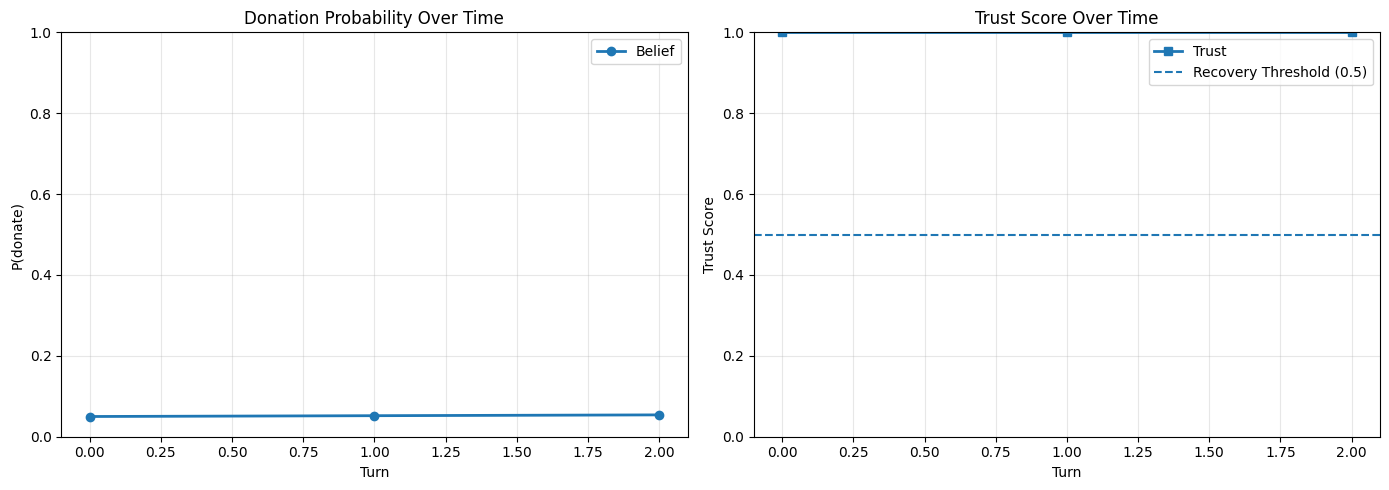


Saved to: dialogue_log.jsonl

COMPLETE!
Log saved: dialogue_log.jsonl

Run again: run_conversation('C1')


In [17]:
# EXECUTION

if __name__ == "__main__":
    print("\n" + "="*80)
    print("SELECT CONDITION")
    print("="*80)
    print("\nC1 - Static (baseline)")
    print("C2 - Adaptive (learns)")
    print("C3 - Adaptive + Trust (recommended)")
    print("="*80)

    cond = input("\nCondition [C3]: ").strip().upper() or 'C3'

    if cond not in ['C1', 'C2', 'C3']:
        print(f"Invalid, using C3")
        cond = 'C3'

    dm = run_conversation(cond)

    print("\nCOMPLETE!")
    print(f"Log saved: {Config.LOG_FILE}")
    print("\nRun again: run_conversation('C1')")